In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.pyplot as plt

from typing import List

from matplotlib.animation import FuncAnimation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
@torch.jit.script
def game_of_life_logic(patterns: torch.Tensor, kernel: torch.Tensor, lam: float) -> torch.Tensor:
    # Pad the patterns tensor with its own edges
    patterns = F.pad(patterns, (1, 1, 1, 1), mode='circular')
    convolution = torch.conv2d((patterns).float(), kernel, padding=1).float()

    t_1 = 1.5
    t_2 = 2.5
    t_3 = 3.5

    # compute new patterns
    new_patterns = patterns.clone().float()

    # conditions:
    cond_0 = (convolution < t_1) | (convolution > t_3)
    cond_1 = (convolution >= t_1) & (convolution < t_2)
    cond_2 = (convolution >= t_2) & (convolution <= t_3)

    # apply the conditions
    new_patterns[cond_0] = new_patterns[cond_0] * (1 - lam)
    new_patterns[cond_1] = new_patterns[cond_1]
    new_patterns[cond_2] = new_patterns[cond_2] * (1 - lam) + lam

    # Remove the padding
    new_patterns = new_patterns[:, :, 1:-1, 1:-1]

    return new_patterns

#@torch.jit.script
def simulate_patterns(patterns: torch.Tensor, T: int, lam: float, kernel: torch.Tensor) -> List[torch.Tensor]:
    '''
    Simulate multiple patterns for T time steps using the game_of_life_logic function,
    return the evolution of the patterns in a list of lists.
    '''

    pattern_list = [patterns]
    for t in tqdm(range(T)):
    
        # simulate the next step
        patterns = game_of_life_logic(patterns, kernel, lam)
        pattern_list.append(patterns)

    return pattern_list

In [3]:
@torch.jit.script
def game_of_life_logic(patterns: torch.Tensor, kernel: torch.Tensor, lam: float) -> torch.Tensor:
    # Pad the patterns tensor with its own edges
    patterns = F.pad(patterns, (1, 1, 1, 1), mode='circular')
    convolution = torch.conv2d((patterns).float(), kernel, padding=1).float()

    patterns = patterns.float()

    # compute new patterns
    new_patterns = patterns.clone()

    # conditions for survival, birth, and death
    cond_survive_1 = (convolution > 1.5) & (convolution < 2.5)
    cond_survive_2 = (convolution > 2.5) & (convolution < 3.5)
    cond_birth_1 = (convolution > 2.5) & (convolution < 3.5)
    cond_birth_2 = (convolution > 5.5) & (convolution < 6.5)
    cond_death = (convolution < 1.5) | (convolution > 3.5)

    # apply the survival rule
    new_patterns[cond_survive_1 & (patterns != 0)] = patterns[cond_survive_1 & (patterns != 0)]
    new_patterns[cond_survive_2 & (patterns != 0)] = patterns[cond_survive_2 & (patterns != 0)]

    # apply the birth rule
    new_patterns[cond_birth_1 & (patterns == 0)] += lam * (1 - patterns[cond_birth_1 & (patterns == 0)])
    new_patterns[cond_birth_2 & (patterns == 0)] += lam * (1 - patterns[cond_birth_2 & (patterns == 0)])

    # apply the death rule
    new_patterns[cond_death & (patterns != 0)] -= lam * patterns[cond_death & (patterns != 0)]

    # Remove the padding
    new_patterns = new_patterns[:, :, 1:-1, 1:-1]

    return new_patterns

#@torch.jit.script
def simulate_patterns(patterns: torch.Tensor, T: int, lam: float, kernel: torch.Tensor) -> List[torch.Tensor]:
    '''
    Simulate multiple patterns for T time steps using the game_of_life_logic function,
    return the evolution of the patterns in a list of lists.
    '''

    pattern_list = [patterns]
    for t in tqdm(range(T)):
    
        # simulate the next step
        patterns = game_of_life_logic(patterns, kernel, lam)
        pattern_list.append(patterns)

    return pattern_list

In [4]:
# generate a random matrix of 0s and 1s
def generate_pattern(size: int, density: float) -> torch.Tensor:
    pattern = torch.rand((size, size), device=device)
    pattern = (pattern < density).float().unsqueeze(0).unsqueeze(0)
    return pattern

def generate_kernel() -> torch.Tensor:
    ker = torch.ones(3, 3, device=device)
    ker[1, 1] = 0
    return ker.unsqueeze(0).unsqueeze(0)


In [5]:
kernel = generate_kernel()
pattern = generate_pattern(100, density=0.6)

In [6]:
#pattern = torch.tensor([[0,0,0,0,0],[0,1,1,1,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,0,0]], device=device).unsqueeze(0).unsqueeze(0)
#pattern = torch.tensor([[0,0,0,0,0],[0,1,1,1,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0]], device=device).unsqueeze(0).unsqueeze(0)
# pad the pattern with zeros
L = 10
pattern = F.pad(pattern, (L,L,L,L), mode='constant', value=0)

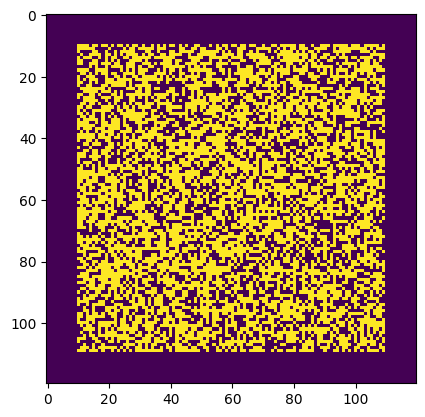

In [7]:
plt.imshow(pattern[0, 0].cpu().numpy())

In [47]:
my_lambda = 1.1
my_lambda = 0.85
my_lambda = 0.78

In [48]:
t = 500
simulated_pattern = simulate_patterns(pattern, T = t, lam = my_lambda, kernel = kernel)

100%|██████████| 500/500 [00:00<00:00, 647.34it/s]


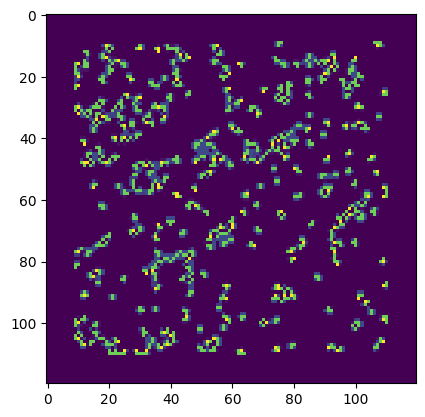

In [49]:
plt.imshow(simulated_pattern[-1][0, 0].cpu().numpy())

In [50]:
def animate_pattern_from_sims(sims, T=80, grid_flag=False, intensity=0.3):
    fig, ax = plt.subplots()
    plt.close(fig)
    img = ax.imshow(sims[0][0][0].to('cpu').numpy())

    def init_animation():
        pattern = sims[0][0][0].to('cpu').numpy()
        img.set_array(pattern)
        if grid_flag:
            ax.grid(alpha = intensity)
        return [img]

    def update_animation(frame):
        pattern = sims[frame][0][0].to('cpu').numpy()
        img.set_array(pattern)
        return [img]
  
    animation = FuncAnimation(fig, update_animation, init_func=init_animation, frames=T, interval=T, blit=True)
    return HTML(animation.to_jshtml())

In [51]:
animate_pattern_from_sims(simulated_pattern, T=t, grid_flag=True)

In [85]:
# plot distribution of states at a given time step and grid
def plot_distribution(patterns, t, grid_flag=False):
    grid = patterns[t][0][0].to('cpu').numpy()
    # flatten grid:
    grid = grid.flatten()

    # plot histogram
    plt.hist(grid, bins=10, color='blue', edgecolor='black', alpha=0.7)

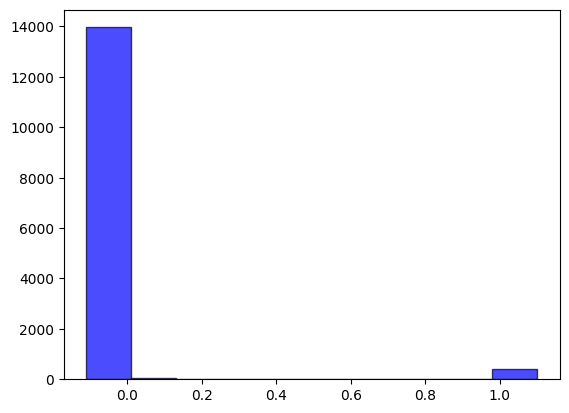

In [86]:
plot_distribution(simulated_pattern, t)

In [87]:
# density at different lambda values

def density_at_lambda(lam, T=100, S = 100):
    densities = []
    for _ in range(100):
        pattern = generate_pattern(S, density=0.6)
        pattern = F.pad(pattern, (L,L,L,L), mode='constant', value=0)
        simulated_pattern = simulate_patterns(pattern, T = T, lam = lam, kernel = kernel)
        density = torch.sum(simulated_pattern[-1]) / ((S + L) * (S + L))
        densities.append(density.item())
    
    mean_density = np.mean(densities)
    return mean_density

In [46]:
density_at_lambda(1.24)

100%|██████████| 100/100 [00:00<00:00, 1538.44it/s]


0.003995574815198779

100%|██████████| 100/100 [00:00<00:00, 1587.34it/s]


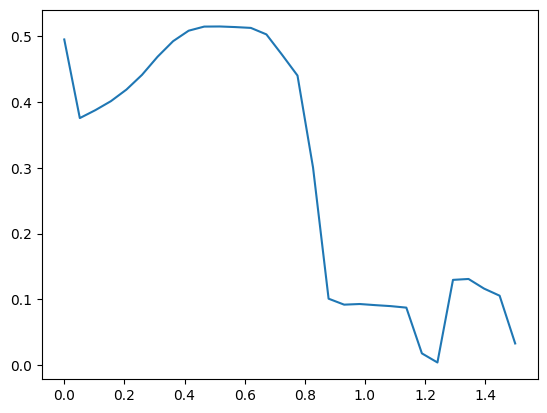

In [47]:
lambda_range = np.linspace(0, 1.5, 30)
density_in_lambda = []
for lam in lambda_range:
    density_in_lambda.append(density_at_lambda(lam))

plt.plot(lambda_range, density_in_lambda)
    
# game of life

In [ ]:
lambda_range = np.linspace(-1, 2, 50)
density_in_lambda = []
for lam in lambda_range:
    density_in_lambda.append(density_at_lambda(lam))

plt.plot(lambda_range, density_in_lambda)

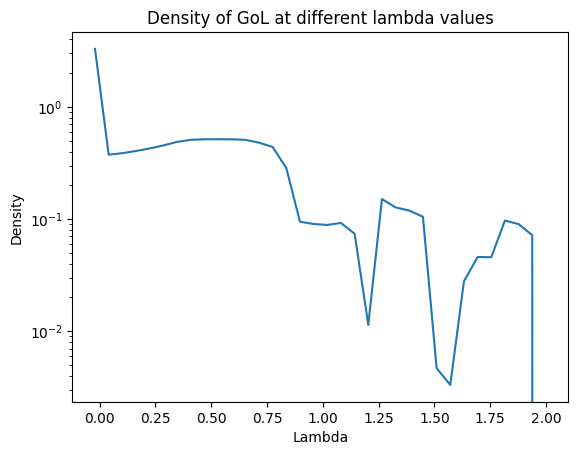

In [60]:
plt.plot(lambda_range[16:], density_in_lambda[16:])
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Lambda')
plt.ylabel('Density')
plt.title('Density of GoL at different lambda values')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 1724.14it/s]


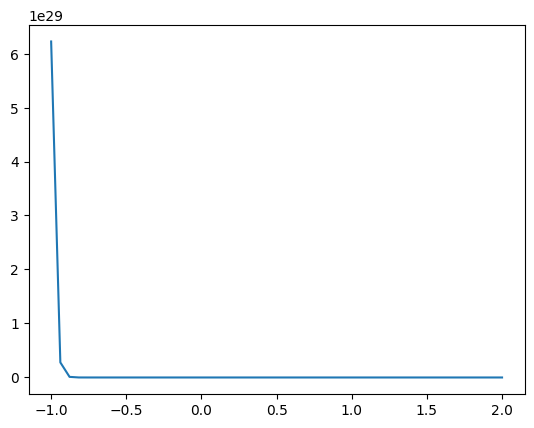

In [62]:
# same study but with a larger grid
lambda_range = np.linspace(-1, 2, 50)
density_in_lambda_large = []
for lam in lambda_range:
    density_in_lambda_large.append(density_at_lambda(lam, S=500))

plt.plot(lambda_range, density_in_lambda_large)

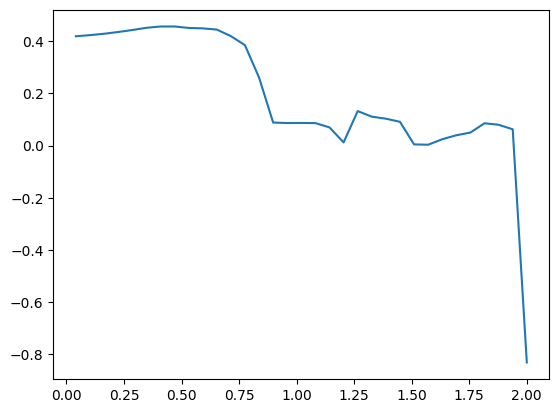

In [67]:
plt.plot(lambda_range[17:], density_in_lambda_large[17:])

# High Life

100%|██████████| 100/100 [00:00<00:00, 763.37it/s]


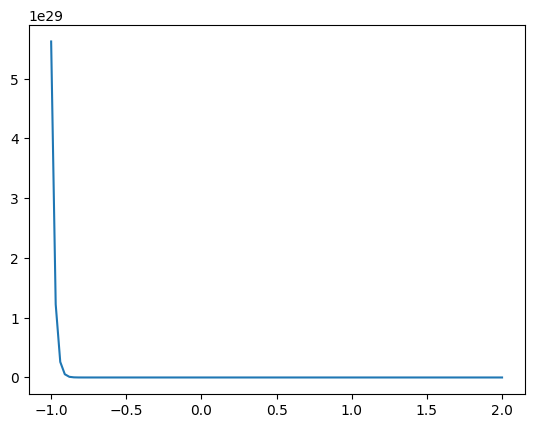

In [95]:
# now with High Life:

lambda_range = np.linspace(-1, 2, 100)
density_in_lambda_large = []
for lam in lambda_range:
    density_in_lambda_large.append(density_at_lambda(lam, S=500))

plt.plot(lambda_range, density_in_lambda_large)

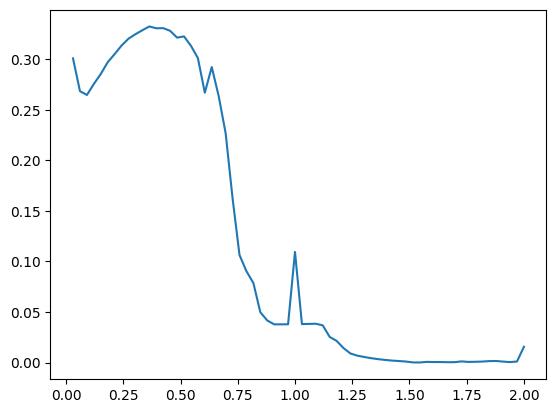

: 

In [104]:

plt.plot(lambda_range[34:], density_in_lambda_large[34:])